In [152]:
# to use R in the notebook
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


import statsmodels.api as sm

# Dimensionality Reduction
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV

# model evaluation
from sklearn import metrics

# classification
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
data_dir = '../input'

In [3]:
visa = pd.read_csv(f'{data_dir}/VisaPremier.txt', delim_whitespace=True)

## Exploration des données:

Il existe des variables qui représentent la même information sous deux formes (chaîne de caractères / entiers)

- cartevp / cartevpr
- sexe / sexer

Les types de variables sont les suivants:
- Categorielles:
    - matricul: identifiant (inutile pour l'analyse et le classement)
    
    - cartevp/cartevpr: possession de la carte Visa Premier (binaire). variable a predire
    - codeqlt: code de qualite du client evalue par la banque (A - E)
    - csp: categorie socio-professionnelle (8 valeurs)
    - departem: departement de residence
    - sexe/sexer: le sexe du client (binaire)
    - sitfamil: situation familiale (6 valeurs)
    
- Numeriques:
    - age: l'age du client (annees)
    - agemvt: age du dernier mouvement (jours)
    - anciente: anciennete de la relation (mois)
    - aveparfi: total des avoirs epargne financiere (francs)
    - aveparmo: total des avoirs epargne monetaire (francs)
    - avtscpte: total des avoirs sur tous les comptes (francs) --> `avtscpte ?= aveparfi + aveparmo + ...`
    - endette: taux d'endettement (pourcentage)
    - engagemc: Total des engagements court terme (francs)
    - engageml: Engagement long terme
    - engagemm: Total des engagements moyen terme
    - engagemt: Total des engagements (francs) --> `engagemt = engagemc + engagemm + engageml`
    - moycred3: Moyenne des mouvements nets créditeurs des 3 mois (milliers de francs)
    - moycredi: Moyenne des mouvements créditeurs (milliers de francs)
    - moysold3: Moyenne des soldes moyens sur 3 mois
    - mtbon: Montant des produits bons et certificats (francs)
    - mteparlo: Montant des produits d’épargne logement (francs)
    - mteparlt: Montant des produits d’épargne long terme (francs)
    - mteparmo: Montant des produits d’épargne monétaire (francs)
    - mteparte: Nombre de produits épargne à terme
    - mtfactur: Montant facturé dans l’année
    - mtlivret: Montant des comptes sur livret (francs)
    - mtrejet: montant total des rejets (francs)
    - mtvie: Montant des produits contrats vie (francs)
    - nbbon: Nombre de produits bons et certificats
    - nbcb: Nombre total de cartes
    - nbcptar:  Nombre de cartes point argent
    - nbcptvue: Nombre de comptes à vue
    - nbeparlo: Nombre de produits d’épargne logement
    - nbeparlt:  Nombre de produits d’épargne long terme
    - nbeparmo: Nombre de produits épargne monétaire
    - nbeparte: Montant des produits épargne à terme
    - nbimpaye: nombre d'impayés en cours
    - nbjdebit: Nombre de jours de débit
    - nblivret: Nombre de comptes sur livret
    - nbop: Nombre d’opérations à M-1
    - nbopguic: nombre d'opérations par gichets dans le mois
    - nbpaiecb: Nombre de paiements par carte bancaire à M-1
    - nbvie: Nombre de produits contrats vie
    - ptvente: point de vente (nombre de points de vente?)

Les valeurs manquantes qui existent dans les variables sont representees par des '.' (ou F.)

In [4]:
visa.columns

Index(['matricul', 'departem', 'ptvente', 'sexe', 'age', 'sitfamil',
       'anciente', 'csp', 'codeqlt', 'nbimpaye', 'mtrejet', 'nbopguic',
       'moycred3', 'aveparmo', 'endette', 'engagemt', 'engagemc', 'engagemm',
       'nbcptvue', 'moysold3', 'moycredi', 'agemvt', 'nbop', 'mtfactur',
       'engageml', 'nbvie', 'mtvie', 'nbeparmo', 'mteparmo', 'nbeparlo',
       'mteparlo', 'nblivret', 'mtlivret', 'nbeparlt', 'mteparlt', 'nbeparte',
       'mteparte', 'nbbon', 'mtbon', 'nbpaiecb', 'nbcb', 'nbcbptar',
       'avtscpte', 'aveparfi', 'cartevp', 'sexer', 'cartevpr', 'nbjdebit'],
      dtype='object')

In [5]:
quali_vars = ['codeqlt', 'csp', 'departem', 'sexe', 'sitfamil'] # 'cartevpr', 'sexer' 
quanti_vars = ['age', 'agemvt', 'anciente', 'aveparfi', 'aveparmo', 'avtscpte',
               'endette', 'engagemc', 'engageml', 'engagemm', 'engagemt',
               'moycred3', 'moycredi', 'moysold3', 'mtbon', 'mteparlo', 'mteparlt',
               'mteparmo', 'mteparte', 'mtfactur', 'mtlivret', 'mtrejet', 'mtvie',
               'nbbon', 'nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt',
               'nbeparmo', 'nbeparte', 'nbimpaye', 'nbjdebit', 'nblivret',
               'nbop', 'nbopguic', 'nbpaiecb', 'nbvie', 'ptvente']

In [7]:
visa.shape

(1073, 48)

### Analyse des valeurs manquantes

In [8]:
na_count = visa.isnull().sum()
na_count[na_count != 0]

Series([], dtype: int64)

In [9]:
visa.matricul.unique().shape

(1073,)

In [10]:
dots = ((visa == '.') | (visa == 'F.'))
dot_count = dots.sum()
pd.DataFrame({
    'NA': dot_count[dot_count != 0],
    'percent_NA': np.round(dot_count[dot_count != 0] / visa.shape[0] * 100, 2)
}, index=dot_count.index[dot_count != 0])

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,NA,percent_NA
departem,7,0.65
sitfamil,32,2.98
codeqlt,133,12.40
agemvt,6,0.56
nbpaiecb,278,25.91


In [102]:
visa[dots] = np.nan
visa.loc[:, quanti_vars] = visa.loc[:, quanti_vars].astype(float)
visa.to_csv('../input/visa.csv', index=False)

In [12]:
visa_quali = visa[quali_vars].copy()
visa_quanti = visa[quanti_vars].copy()

### Analyse univariée

Text(0.5, 1.0, 'cartevp distribution')

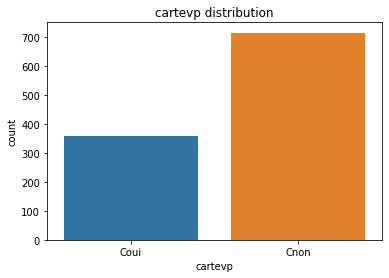

In [13]:
sns.countplot(x=visa.cartevp)
plt.title(f'cartevp distribution')

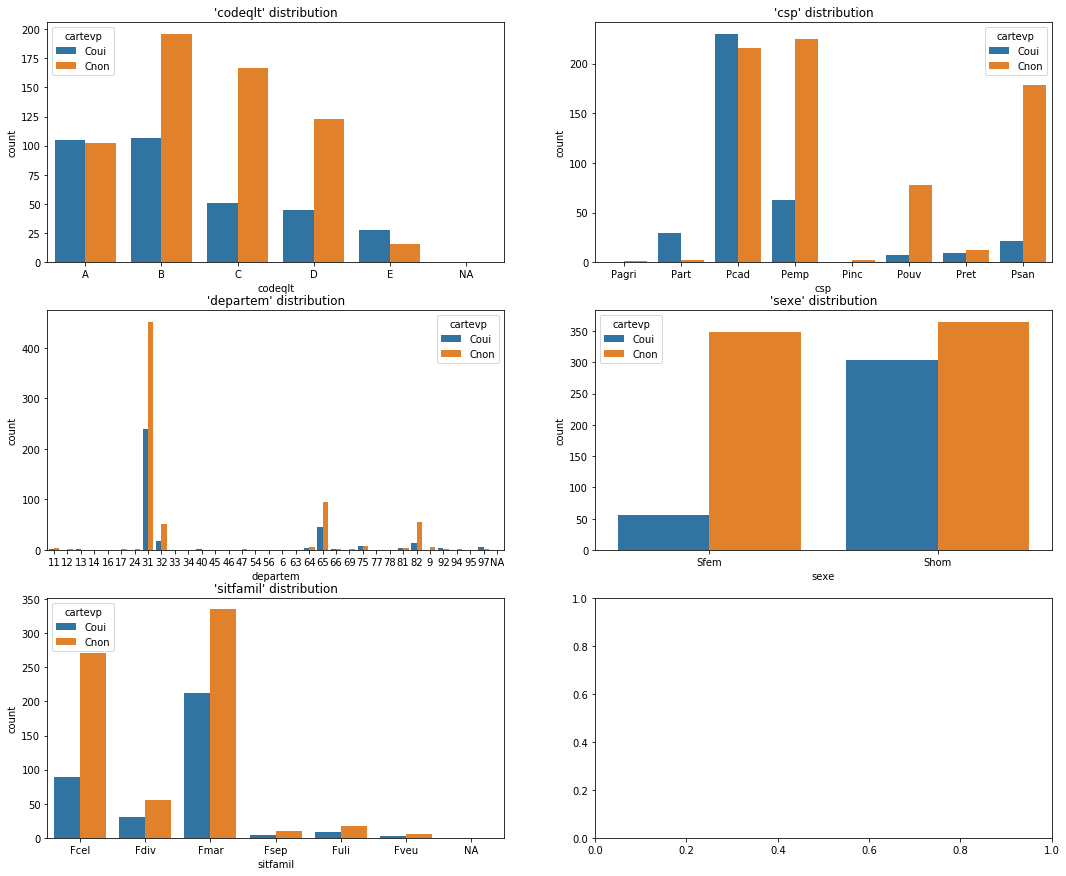

In [14]:
nrow, ncol = 3,2
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(visa_quali.shape[1]):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = quali_vars[i]
    
#     visa_quali[var_name].value_counts().sort_index().plot.bar(ax=ax)
    order=np.sort(visa_quali[var_name].fillna('NA').unique())
    sns.countplot(x=visa_quali[var_name], hue=visa.cartevp,
                  order=order, 
                  ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [15]:
# nvars = visa_quanti.shape[1]
# ncol = 5
# nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
# fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

# for i in range(nvars):
#     row, col = i//ncol, i%ncol
#     ax = axs[row, col]
#     var_name = visa_quanti.columns[i]
    
#     s = visa_quanti[var_name]#.astype('str')
# #     s = s[s != '.'].astype(int) # elimination des valeurs manquantes et transformation en entier
# #     s.plot.hist(ax=ax)
#     sns.boxplot(x=visa.cartevp, y=s, ax=ax)
#     ax.yaxis.set_major_formatter(ticker.EngFormatter())
#     ax.set_title(f'{var_name!r} distribution')

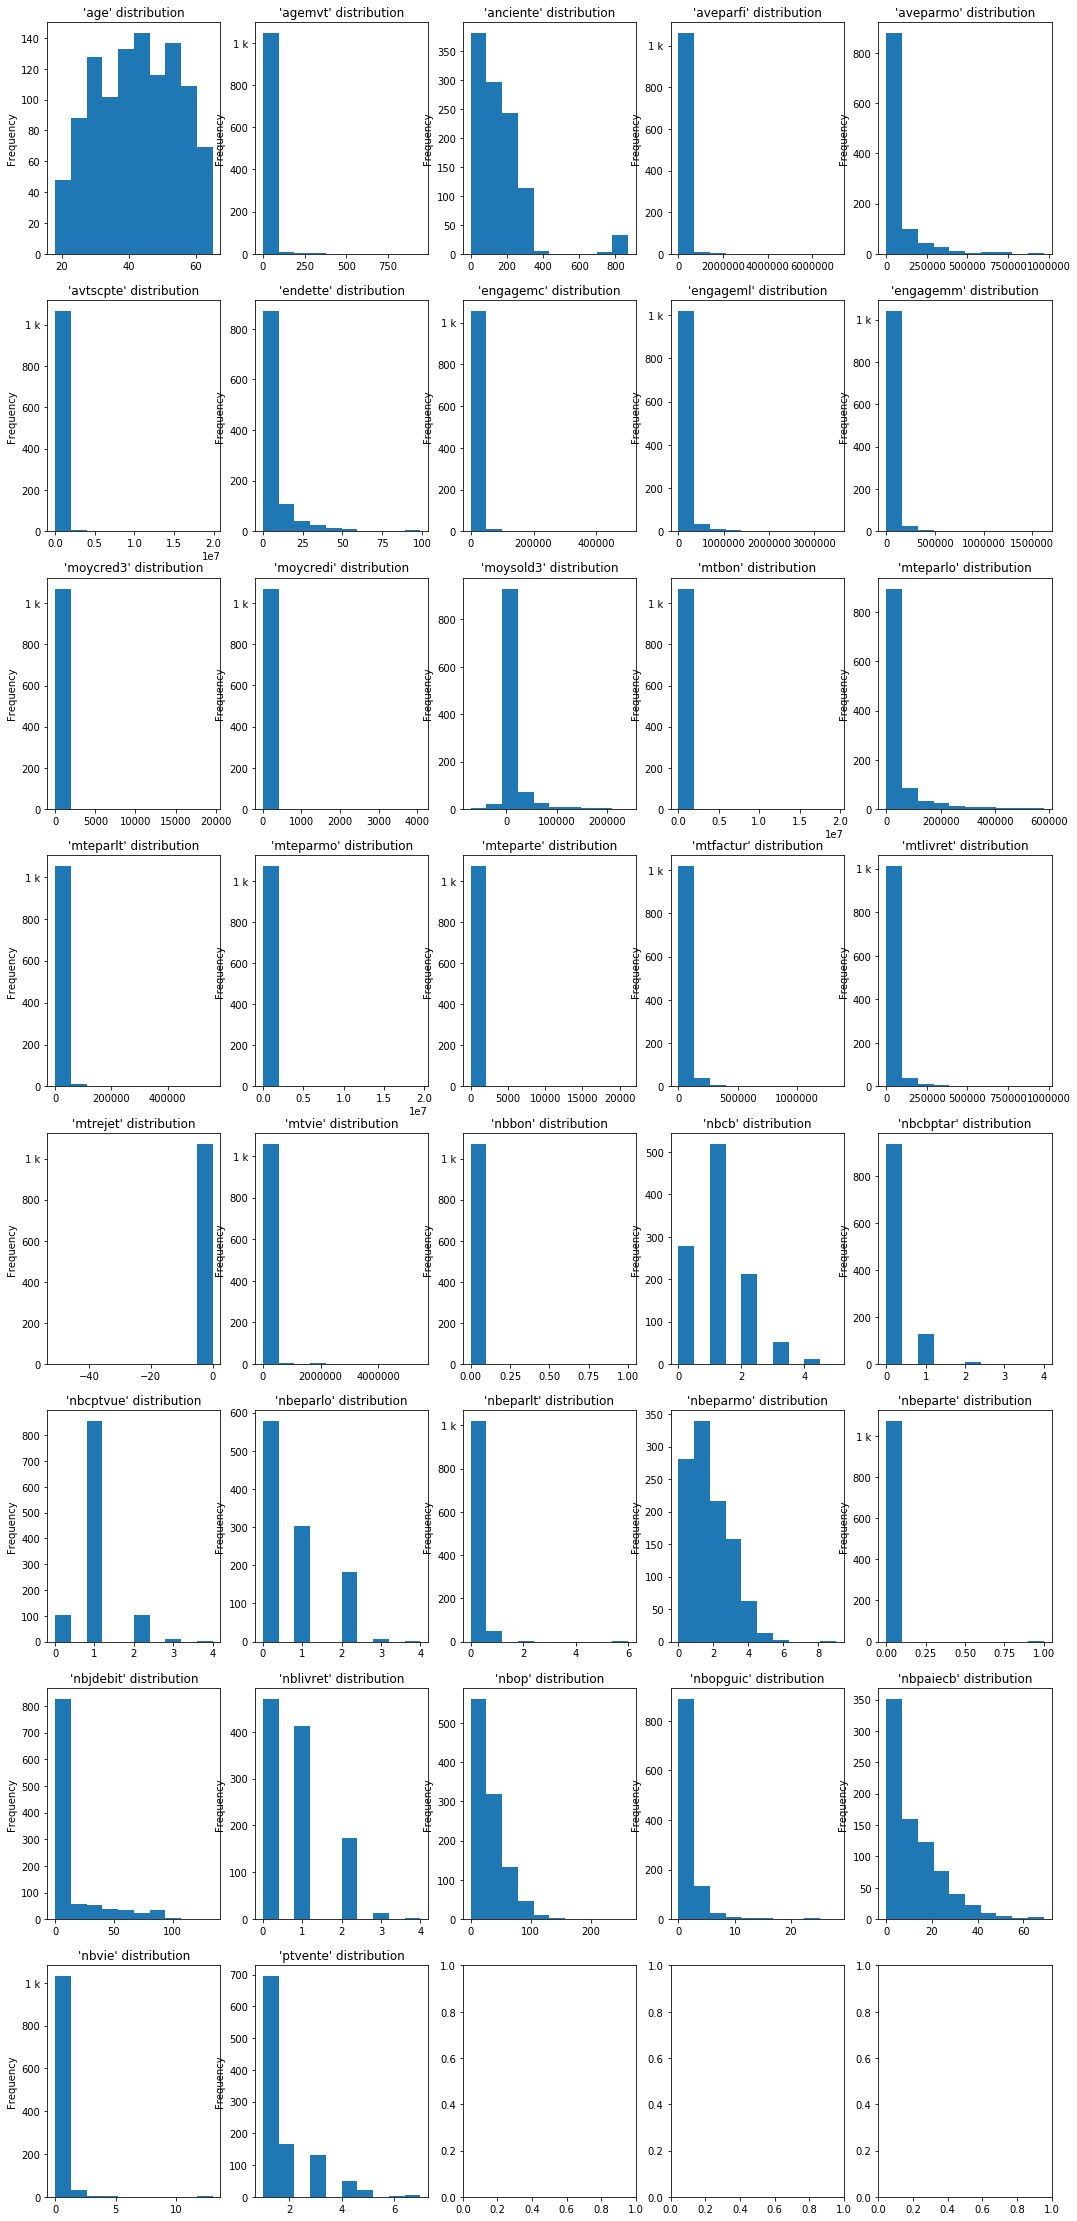

In [124]:
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_quanti.columns[i]
    
    s = visa_quanti[var_name]
    s.plot.hist(ax=ax)
#     sns.distplot(s, ax=ax)
#     [sns.distplot(s[visa.cartevp==label], label=f"class {label}") for label in visa.cartevp.unique()]
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [126]:
visa_log = visa_quanti.drop(columns=['nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt', 'nbeparte',
                                     'nblivret', 'nbvie', 'ptvente']).copy()
visa_log = visa_log.apply(lambda x: np.log(np.abs(x)+1))

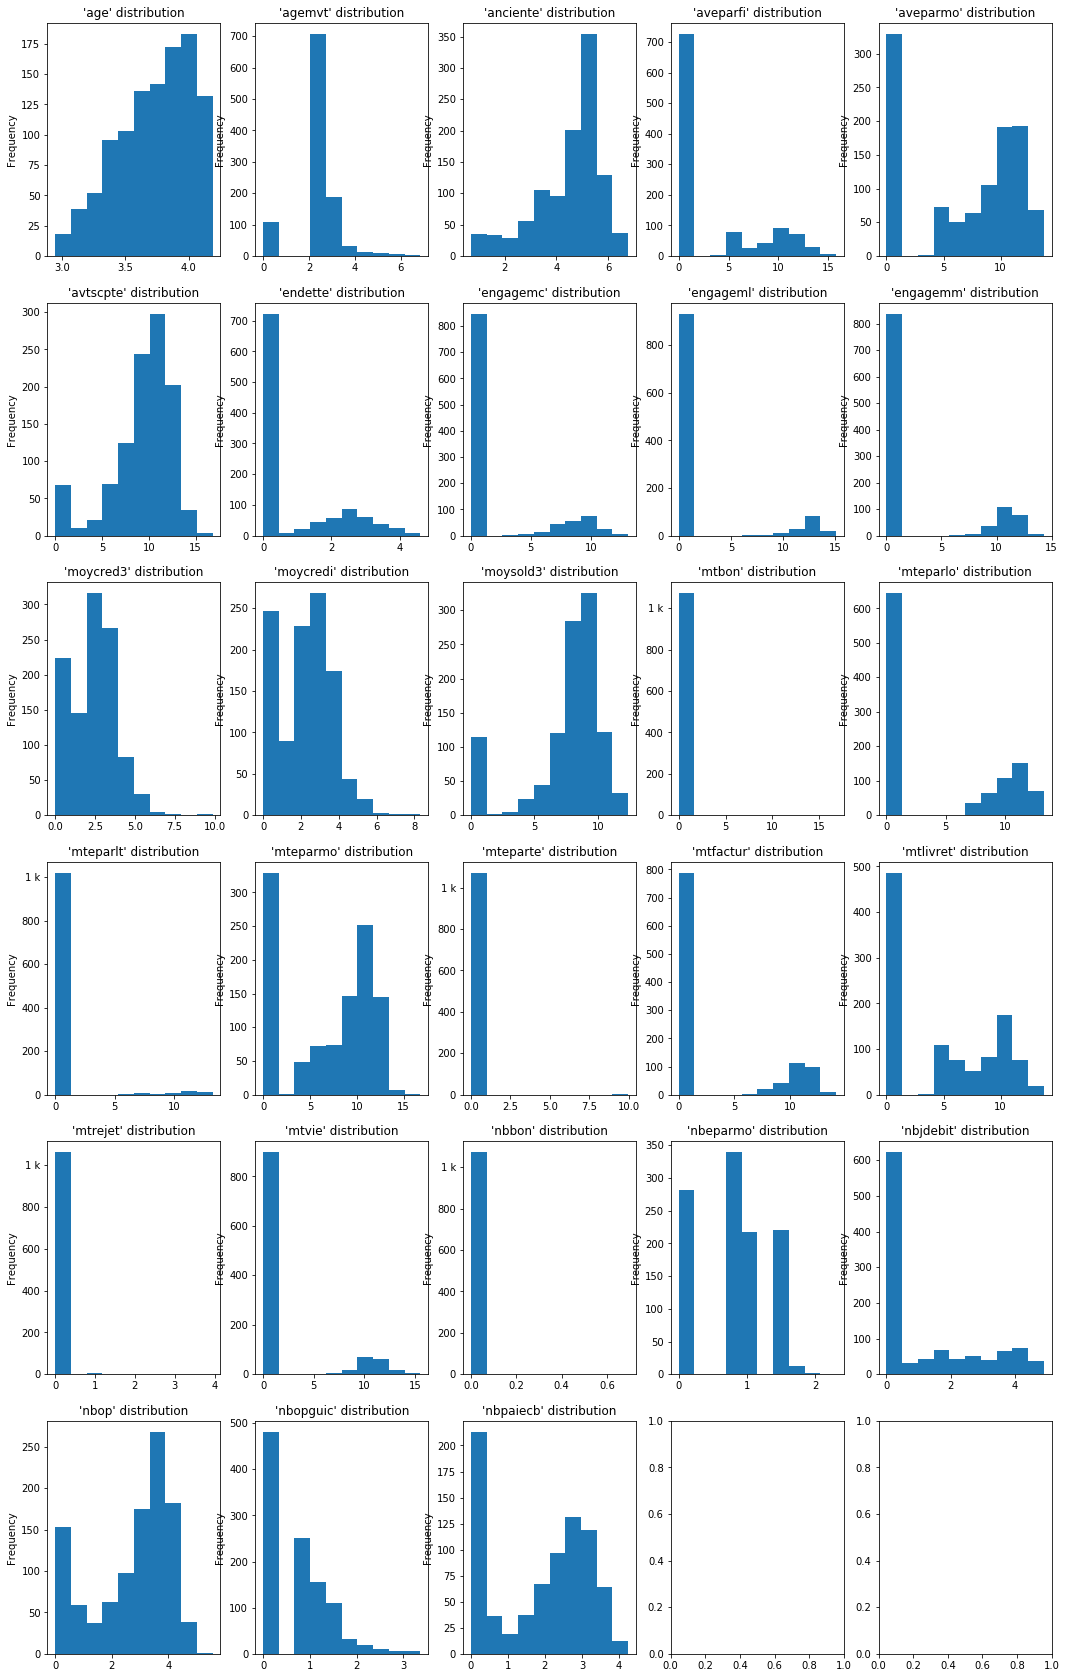

In [129]:
nvars = visa_log.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

# to_rescale[]

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_log.columns[i]
    
    s = visa_log[var_name]
#     sns.boxplot(x=visa.cartevp, y=np.log(np.abs(s)+1), ax=ax)
    s.plot.hist(ax=ax)
#     sns.distplot(np.log(s), ax=ax)
#     [sns.distplot(s[visa.cartevp==label], label=f"class {label}") for label in visa.cartevp.unique()]
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [116]:
visa.nbimpaye.value_counts()

0.0    1073
Name: nbimpaye, dtype: int64

In [6]:
# visa[['aveparfi', 'aveparmo']].sum(axis=1).head(), visa.avtscpte.head()
# (visa[['engagemc', 'engagemm', 'engageml']].sum(axis=1).head() != visa.engagemt.head()).sum()

#### Suppression des variables inutiles
- On supprime `nbimpaye` parce que sa valeur est constante
- On supprime `engagemt` parce que sa valeur peut être calculée en fonction des variables `engagemc`, `engagemm` et `engageml`

In [118]:
visa = visa.drop(columns=['nbimpaye', 'engagemt'])
visa_quanti = visa_quanti.drop(columns=['nbimpaye', 'engagemt'])

### Analyse multivariée

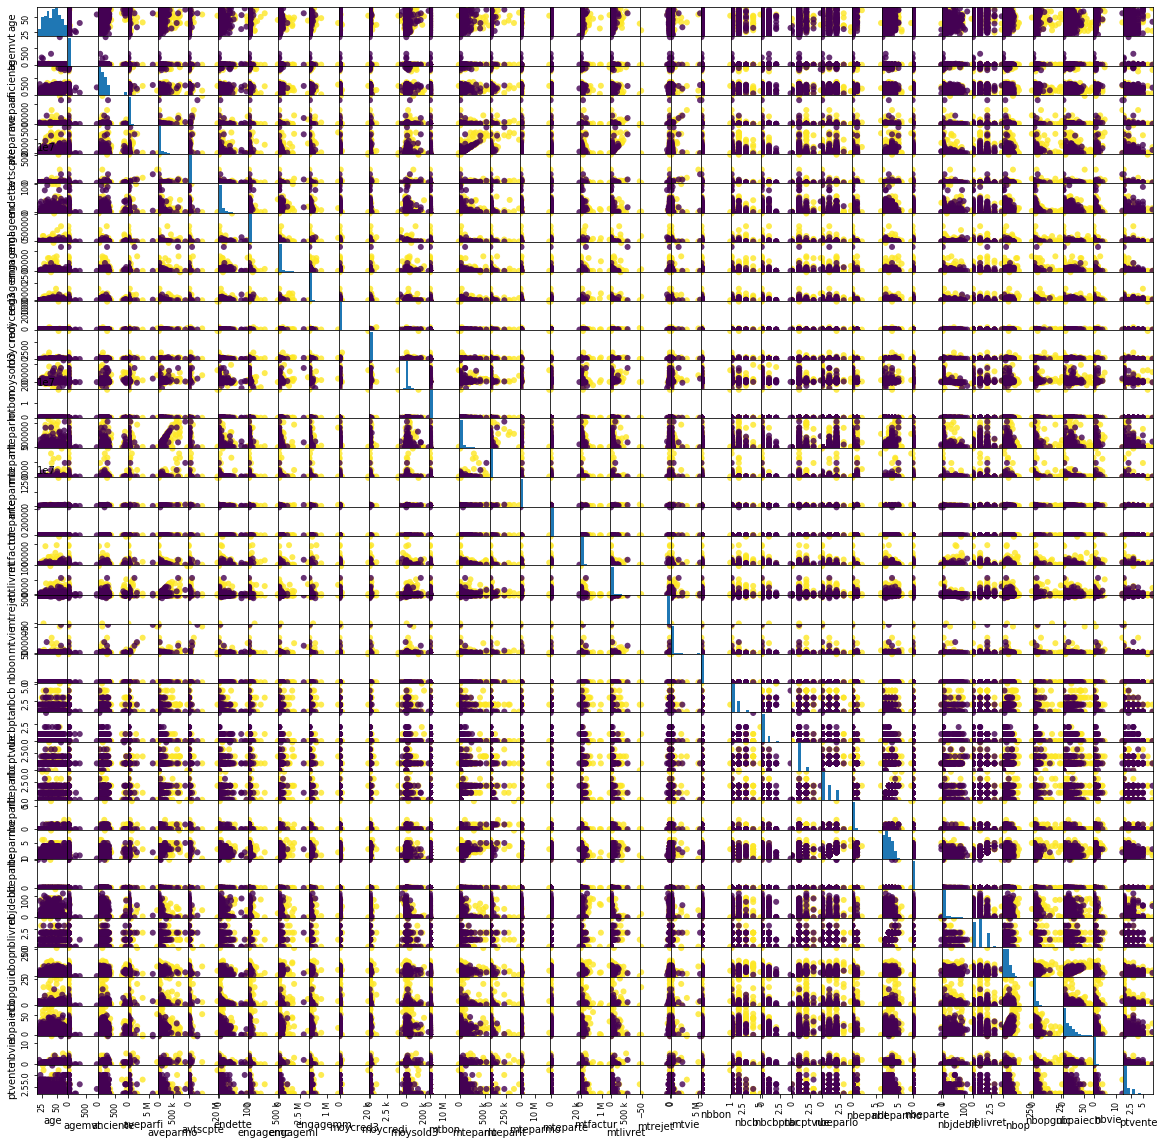

In [119]:
# sns.pairplot(visa_quanti.iloc[:,:4], hue=visa.cartevpr)
axs = pd.plotting.scatter_matrix(visa_quanti.dropna(), #.iloc[:, :4],
                           c=visa.cartevpr[~visa_quanti.isnull().any(axis=1)],
                           figsize=(20, 20),
                           marker='o', alpha=.8)
for ax in axs.flat:
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
#     ax.yaxis.set_major_formatter(ticker.EngFormatter())
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)

In [130]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

M = np.ones((7,7))
upper_tri_masking(M)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [146]:
r = np.arange(5)
mask = r[:,None] < r
mask
df = pd.DataFrame(r[:, None] + r)
df.values[mask] = 0
df

,0,1,2,3,4
0,0,0,0,0,0
1,1,2,0,0,0
2,2,3,4,0,0
3,3,4,5,6,0
4,4,5,6,7,8


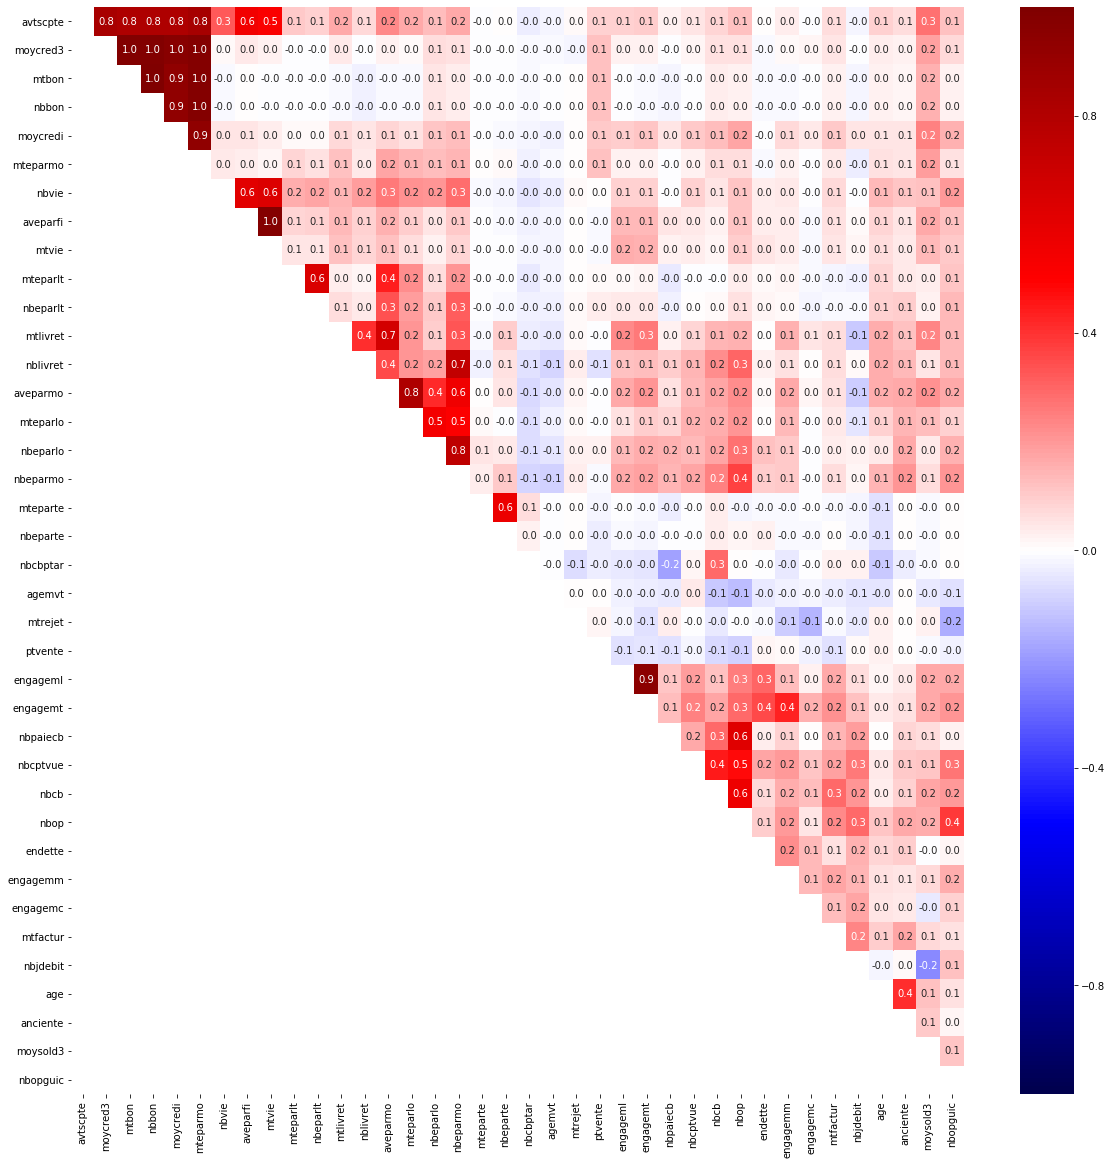

In [147]:
from scipy.cluster import hierarchy
def corplot(df):
    corr = df.corr() # calculate correlations
    d = 2 - 2*corr.values # convert to euclidean distances

    # creation of the dendrogram
    Z = hierarchy.linkage(d, method='ward')
    dn = hierarchy.dendrogram(Z,no_plot=True)
    idx = dn['leaves']
    
    # reorder rows and columns according to the order of the leaves
    cor = corr.copy()
    cor = cor.iloc[:, idx]
    cor = cor.iloc[idx, :]
    
    # delete the values under the diagonal
    idx = np.arange(cor.shape[0])
    mask = idx[:, np.newaxis] < idx
    cor.values[~mask] = np.nan
    

    ax = sns.heatmap(cor, annot=True, fmt='.1f', cmap='seismic', vmin=-1, vmax=1)
    # adjust ticks (problem on windows)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.figure(figsize=(20,20))
df = visa_quanti_new.drop(columns=['nbimpaye'])
corplot(df)

### Remplacement des valeurs manquantes:
Pour les variables numériques, nous utilisons la moyenne.
Pour les variables catégorielles, nous utilisons la modalité modale

In [88]:
new_vals = SimpleImputer().fit_transform(visa_quanti)
visa_quanti_new = pd.DataFrame(new_vals, columns=visa_quanti.columns)

new_vals = SimpleImputer(strategy='most_frequent').fit_transform(visa_quali)
visa_quali_new = pd.DataFrame(new_vals, columns=visa_quali.columns)

#### Réduction de la dimension

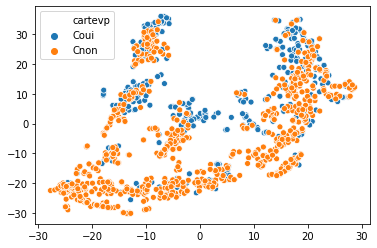

In [89]:
tsne_embed = TSNE(perplexity=50).fit_transform(visa_quanti_new)
sns.scatterplot(tsne_embed[:,0], tsne_embed[:,1], hue=visa.cartevp)

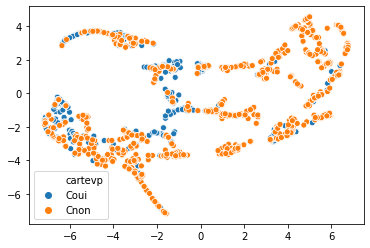

In [90]:
umap_embed = UMAP().fit_transform(visa_quanti_new)
sns.scatterplot(umap_embed[:,0], umap_embed[:,1], hue=visa.cartevp)

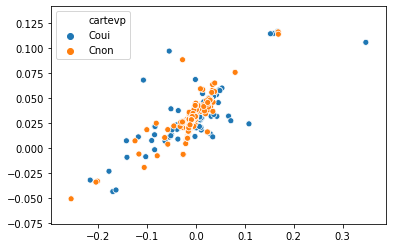

In [91]:
lle_embed = LocallyLinearEmbedding().fit_transform(visa_quanti_new)
sns.scatterplot(lle_embed[:,0], lle_embed[:,1], hue=visa.cartevp)

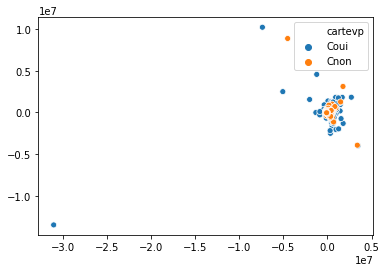

In [92]:
mds_embed = MDS().fit_transform(visa_quanti_new)
sns.scatterplot(mds_embed[:,0], mds_embed[:,1], hue=visa.cartevp)

In [93]:
visa_new = pd.concat([visa_quanti_new, visa_quali_new, visa.cartevp], axis=1)

In [105]:
%%R -i visa_new -o afdm
df <- visa_new

library(FactoMineR)
library(tidyverse)

n <- nrow(df)
p <- ncol(df)

df[, (p-4):p] <- lapply(df[, (p-4):p], factor)
summary(df[, (p-4):p])

y_idx <- which(colnames(df) == 'cartevp')
afdm <- FAMD(df,ncp=ncol(df), graph=FALSE, sup.var=y_idx)
head(afdm$var$coord[, 1:2])

               Dim.1       Dim.2
age      0.059871073 0.034963910
agemvt   0.008055521 0.006463036
anciente 0.061241129 0.044095583
aveparfi 0.113377404 0.023081121
aveparmo 0.298344618 0.233744401
avtscpte 0.645836986 0.199690981


From cffi callback <function _processevents at 0x7f58cee47ae8>:
Traceback (most recent call last):
  File "/mnt/c/python-envs/mlds/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f58cee47ae8>:
Traceback (most recent call last):
  File "/mnt/c/python-envs/mlds/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f58cee47ae8>:
Traceback (most recent call last):
  File "/mnt/c/python-envs/mlds/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f58cee47ae8>:
Traceback (most recent call last):
  File "/mnt/c/pyth

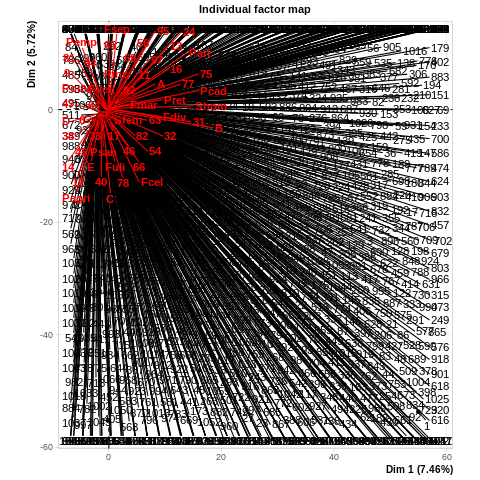

In [114]:
%%R -i afdm -i visa_new
X = data.frame(afdm$ind$coord[, 1:2])
# print(dim(X))
# print(length(visa_new$cartevp))
# ggplot(data = X) + geom_point(aes(x = Dim.1, y= Dim.2, color = visa_new$cartevp))
plot(afdm)

## Classification supervisée

### Préparation des données

In [123]:
cat_vars=visa_quali.copy()
cat_list = pd.get_dummies(cat_vars.drop(columns=['sexe']), drop_first=True)
cat_list = cat_list.assign(sexe=visa_quali.replace({"sexe": {'Shom': 0, 'Sfem': "B"}}).sexe)
cat_list.columns
# data=data.join(cat_list)
# data=data[[i for i in log if i not in cat_vars]]
# x=data[[i for i in log if i not in y]]

Index(['codeqlt_B', 'codeqlt_C', 'codeqlt_D', 'codeqlt_E', 'csp_Part',
       'csp_Pcad', 'csp_Pemp', 'csp_Pinc', 'csp_Pouv', 'csp_Pret', 'csp_Psan',
       'departem_12', 'departem_13', 'departem_14', 'departem_16',
       'departem_17', 'departem_24', 'departem_31', 'departem_32',
       'departem_33', 'departem_34', 'departem_40', 'departem_45',
       'departem_46', 'departem_47', 'departem_54', 'departem_56',
       'departem_6', 'departem_63', 'departem_64', 'departem_65',
       'departem_66', 'departem_69', 'departem_75', 'departem_77',
       'departem_78', 'departem_81', 'departem_82', 'departem_9',
       'departem_92', 'departem_94', 'departem_95', 'departem_97',
       'sitfamil_Fdiv', 'sitfamil_Fmar', 'sitfamil_Fsep', 'sitfamil_Fuli',
       'sitfamil_Fveu', 'sexe'],
      dtype='object')

In [150]:
dataset = visa_quanti_new



# Split-out validation dataset
array = dataset.values
# X = array[:,0:60].astype(float)
# Y = array[:,60]
X = array.astype(float)
Y = visa.cartevpr.values
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


# Evaluate Algorithms

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

## Classification supervisée

#### Obtention du meilleur modèle pour chaque algorithme

In [ ]:
def 

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

LR: 0.7856 (0.05834)
LDA: 0.8311 (0.03517)
KNN: 0.7646 (0.04644)
CART: 0.8520 (0.02929)
NB: 0.7390 (0.04610)
SVM: 0.6679 (0.04459)


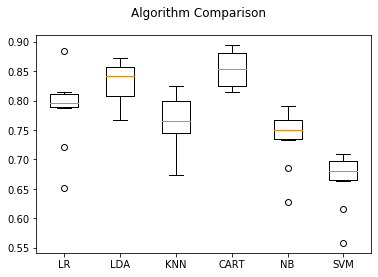

In [151]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.5f})"
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

ScaledLR: 0.752969 (0.040232)
ScaledLDA: 0.723871 (0.046903)
ScaledKNN: 0.750643 (0.045085)
ScaledCART: 0.700397 (0.057831)
ScaledNB: 0.730780 (0.049425)
ScaledSVM: 0.748290 (0.045508)


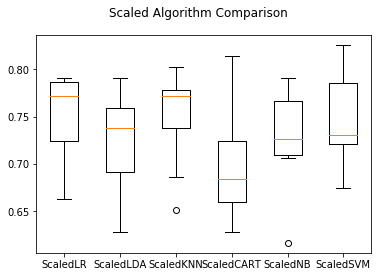

Best: 0.756410 using {'n_neighbors': 3}
0.729604 (0.033576) with: {'n_neighbors': 1}
0.756410 (0.053839) with: {'n_neighbors': 3}
0.755245 (0.049860) with: {'n_neighbors': 5}
0.748252 (0.050869) with: {'n_neighbors': 7}
0.751748 (0.041307) with: {'n_neighbors': 9}
0.736597 (0.034610) with: {'n_neighbors': 11}
0.737762 (0.044729) with: {'n_neighbors': 13}
0.731935 (0.050888) with: {'n_neighbors': 15}
0.726107 (0.057451) with: {'n_neighbors': 17}
0.728438 (0.058430) with: {'n_neighbors': 19}
0.723776 (0.060088) with: {'n_neighbors': 21}
Best: 0.750583 using {'C': 1.0, 'kernel': 'rbf'}
0.735431 (0.042853) with: {'C': 0.1, 'kernel': 'linear'}
0.698135 (0.049825) with: {'C': 0.1, 'kernel': 'poly'}
0.735431 (0.047795) with: {'C': 0.1, 'kernel': 'rbf'}
0.722611 (0.053195) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.741259 (0.044560) with: {'C': 0.3, 'kernel': 'linear'}
0.699301 (0.052328) with: {'C': 0.3, 'kernel': 'poly'}
0.748252 (0.043718) with: {'C': 0.3, 'kernel': 'rbf'}
0.714452 (0.045086) 

In [19]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs', max_iter=1000))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


AB: 0.778564 (0.037813)
GBM: 0.770424 (0.031468)
RF: 0.749508 (0.035954)


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/mnt/c/python-envs/mlds/lib/python3.7/si

ET: 0.764501 (0.025543)


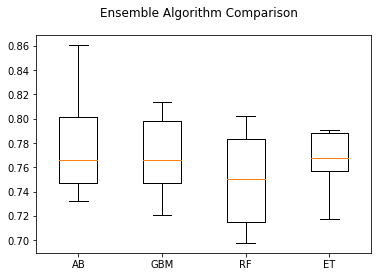

0.7209302325581395
[[130  11]
 [ 49  25]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       141
           1       0.69      0.34      0.45        74

    accuracy                           0.72       215
   macro avg       0.71      0.63      0.63       215
weighted avg       0.72      0.72      0.69       215



In [20]:
# ensembles
ensembles = [
    ('AB', AdaBoostClassifier(), None),
    ('GBM', GradientBoostingClassifier(), None),
    ('RF', RandomForestClassifier(), None),
    ('ET', ExtraTreesClassifier(), None)
]

results = []
names = []
for name, model, cv_params in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



# Finalize Model

# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=1.5)
model.fit(rescaledX, Y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

#### Methodes ensemblistes 

In [21]:
# # Bagged Decision Trees for Classification
# from pandas import read_csv
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier
# filename = 'pima-indians-diabetes.data.csv'
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = read_csv(filename, names=names)
# array = dataframe.values
# X = array[:,0:8]
# Y = array[:,8]
# seed = 7
# kfold = KFold(n_splits=10, random_state=seed)
# cart = DecisionTreeClassifier()
# num_trees = 100
# model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
# results = cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())


In [22]:
# # Stochastic Gradient Boosting Classification
# from pandas import read_csv
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import GradientBoostingClassifier
# filename = 'pima-indians-diabetes.data.csv'
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = read_csv(filename, names=names)
# array = dataframe.values
# X = array[:,0:8]
# Y = array[:,8]
# seed = 7
# num_trees = 100
# kfold = KFold(n_splits=10, random_state=seed)
# model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
# results = cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())


In [23]:
# # Voting Ensemble for Classification
# from pandas import read_csv
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import VotingClassifier
# filename = 'pima-indians-diabetes.data.csv'
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = read_csv(filename, names=names)
# array = dataframe.values
# X = array[:,0:8]
# Y = array[:,8]
# kfold = KFold(n_splits=10, random_state=7)
# # create the sub models
# estimators = []
# model1 = LogisticRegression()
# estimators.append(('logistic', model1))
# model2 = DecisionTreeClassifier()
# estimators.append(('cart', model2))
# model3 = SVC(gamma='auto')
# estimators.append(('svm', model3))
# # create the ensemble model
# ensemble = VotingClassifier(estimators)
# results = cross_val_score(ensemble, X, Y, cv=kfold)
# print(results.mean())
